In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [3]:
nrc = pynrc.NIRCam(filter='F277W', pupil='GRISM90', mask='MASK430R', fov_pix=255, oversample=2)

In [4]:
# Stellar spectrum (HR 8799)
sp_star = pynrc.stellar_spectrum('A5V', 5.2, 'vegamag', nrc.bandpass)
w_star, im_star = nrc.gen_psf(sp=sp_star)

In [5]:
# Exoplanet spectrum
pl_obj = pynrc.planets_sb12(mass=5, age=30, entropy=13, distance=40)
sp_pl = pl_obj.export_pysynphot()

# Planet spectral image
w_pl, im_pl = nrc.gen_psf(sp=sp_pl, use_bg_psf=True)

# Expand planet image to that of im_star
im_pl_full = nrc_utils.pad_or_cut_to_size(im_pl, im_star.shape)

In [50]:
# Shift by 1", 2", 3", 4"
im_pl_shift = np.zeros_like(im_star)
for dx_asec in [1,2,3,4]:
    dx = int(dx_asec / nrc.pix_scale)
    print(dx)
    im_pl_shift += nrc_utils.fshift(im_pl_full, delx=dx)

15
31
47
63


In [26]:
im_tot = im_star + im_pl_shift

In [27]:
# Update WFE drift
nrc.wfe_drift=5

In [28]:
# Get reference star spectrum
w_ref, im_ref = nrc.gen_psf(sp=sp_star)

In [29]:
# Subtract reference star
im_diff = im_tot - im_ref

In [30]:
im_arr = [im_star, im_pl_shift, im_diff]
for i, im in enumerate(im_arr):
    im_arr[i] = nrc_utils.pad_or_cut_to_size(im, (800,200))

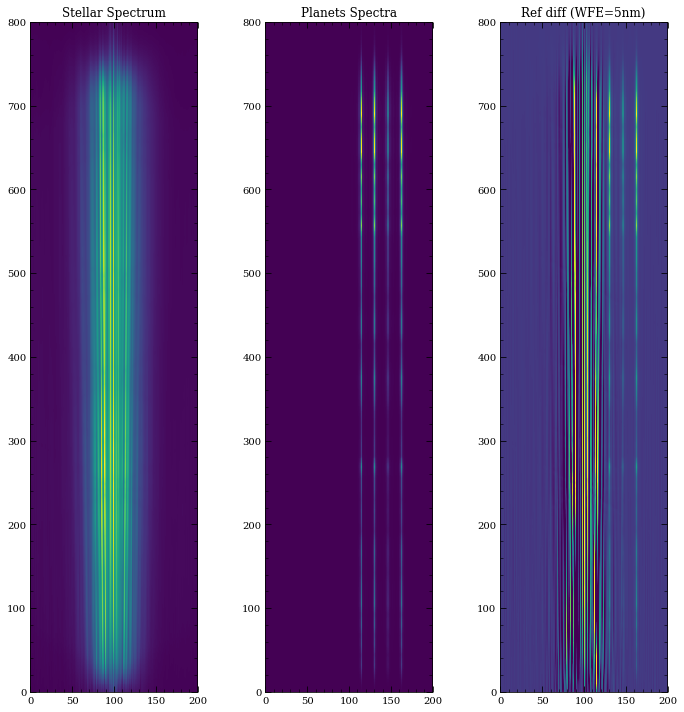

In [48]:
fig, axes = plt.subplots(1,3, figsize=(10,10))

lab_arr = ['Stellar Spectrum', 'Planets Spectra', 'Ref diff (WFE=5nm)']
for i, im in enumerate(im_arr):
    ax = axes[i]
    if i<2:
        vmax = im.max()
    vmin = -vmax/5 if i==2 else 0
    ax.imshow(im, vmin=vmin, vmax=vmax)
    ax.set_title(lab_arr[i])
    
fig.tight_layout()
fig.savefig('grism_coronagraphy_F277W.pdf')

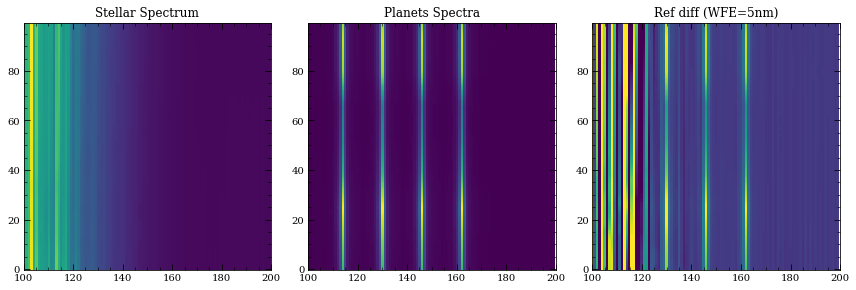

In [49]:
fig, axes = plt.subplots(1,3, figsize=(12,5))

lab_arr = ['Stellar Spectrum', 'Planets Spectra', 'Ref diff (WFE=5nm)']
for i, im in enumerate(im_arr):
    ax = axes[i]
    
    imsub = nrc_utils.pad_or_cut_to_size(im, (100,200))
    
    if i<2:
        vmax = imsub.max()
    vmin = -vmax/5 if i==2 else 0
    ax.imshow(imsub, vmin=vmin, vmax=vmax)
    ax.set_title(lab_arr[i])
    
    ax.set_xlim([100,200])
    
fig.tight_layout()
fig.savefig('grism_coronagraphy_F277W_zoom.pdf')

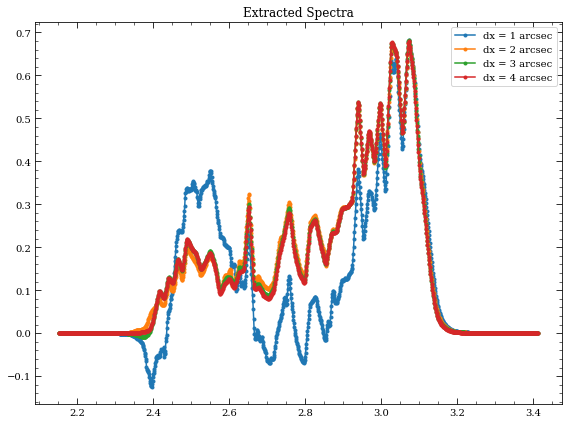

In [108]:
dx_arr = np.array([15,31,47,63])


fig, ax = plt.subplots(1,1, figsize=(8,6))
for i, dx in enumerate(dx_arr):
    xind0 = int(im_diff.shape[1]/2) + dx
    xind1 = xind0 - 2
    xind2 = xind1 + 5
    #print(xind0, xind1, xind2)

    spec = im_diff[:,xind1:xind2].sum(axis=1)
    #print(spec.max())
    ax.plot(w_star,spec, label='dx = {} arcsec'.format(i+1), marker='.')

ax.legend()
ax.set_title("Extracted Spectra")
fig.tight_layout()

fig.savefig('grism_coronagraphy_extracted.pdf')

In [56]:
xind

190

In [57]:
im_diff.shape

(1265, 255)

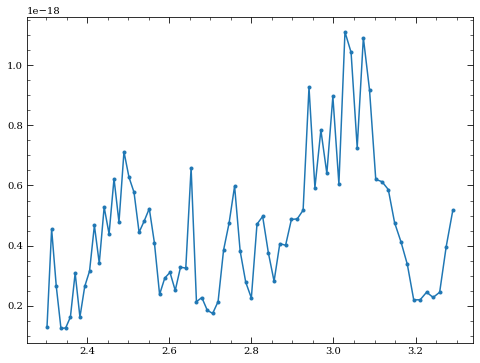

In [117]:
ind = (sp_pl.wave>2.3e4) & (sp_pl.wave<3.3e4)
plt.plot(sp_pl.wave[ind]/1e4, sp_pl.flux[ind], marker='.')


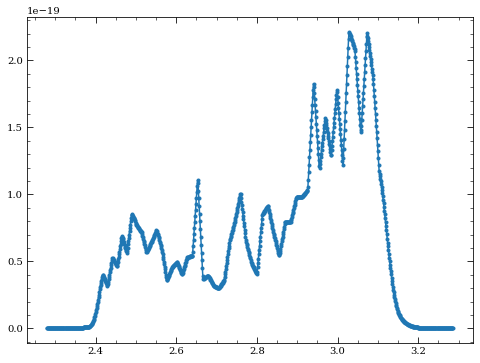

In [103]:
obs = S.Observation(sp_pl, nrc.bandpass, nrc.bandpass.wave)
plt.plot(obs.binwave/1e4, obs.binflux, marker='.')

In [92]:
obs.convert('counts')

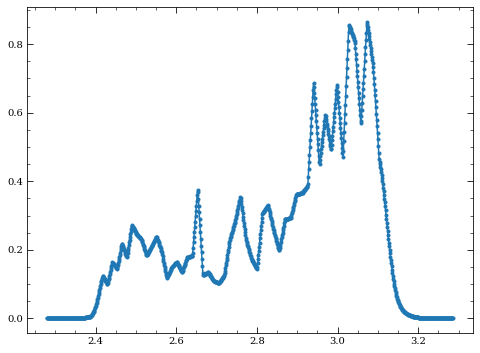

In [102]:
plt.plot(obs.binwave/1e4, obs.binflux, marker='.')

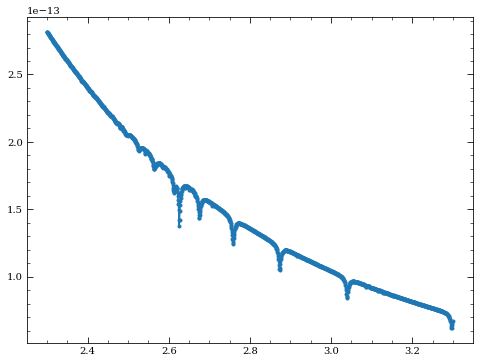

In [115]:
ind = (sp_star.wave>2.3e4) & (sp_star.wave<3.3e4)
plt.plot(sp_star.wave[ind]/1e4, sp_star.flux[ind], marker='.')
#plt.xlim([2.3,3.3])

In [21]:
obs.countrate()

2724.416247486975